# Theory

In [250]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


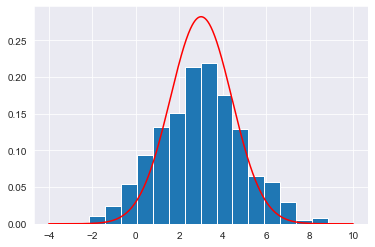

In [275]:
# set the random seed
rng = np.random.default_rng(42)
# generate a sample of normally distributed random variables with mean mu and variance var
mu = 3
var = 2
# generate a random sample using the numpy function
sample = rng.normal(mu, var, 500)

def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Maximum Likelihood Estimation

Here we minimise the likelihood function for the univariate Gaussian pdf. This allows us to find the best-fitting parameters.

The log-likelihood of the univariate Gaussian is given by:

$$\log \mathcal{L}(\mu, \sigma^{2}| \vec{x}) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log \sigma^{2} - \frac{1}{2\sigma^{2}}\sum_{i = 1}^{n} (x_{i} - \mu)^{2}$$

and hence we want to minimise

$$\hat{\mu} = -\text{argmin}_{\mu} \log \mathcal{L}(\mu, \sigma^{2} | \vec{x})$$

In [276]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = params
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

## Evaluating the likelihood function

Evaluating the likelihood function over a range of values, we can geometrically approximate the MLE to be zero.

Text(0.5, 0, '$Mean value: \\mu$')

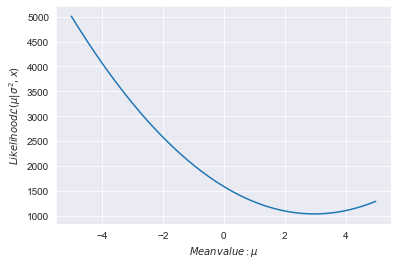

In [277]:
mu = np.arange(-5, 5, 0.01)
likelihood_values = []

for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
plt.plot(mu, likelihood_values)
plt.ylabel("$Likelihood \mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("$Mean value: \mu$")

## Minimising the likelihood function using scipy.optimize.minimize

In [278]:
initial_guess = rng.random()

lik_model = minimize(likelihood, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 28
         Function evaluations: 56


array([2.97374775])

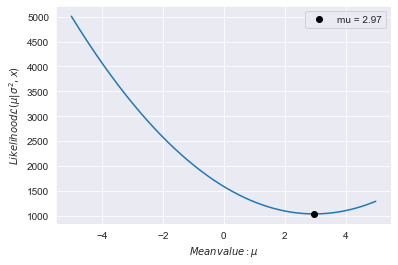

In [279]:
plt.plot(mu, likelihood_values)
plt.ylabel("$Likelihood \mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("$Mean value: \mu$")
plt.plot(lik_model.x, lik_model.fun, 'ko', label=f"mu = {lik_model.x[0]:.2f}")
plt.legend()

## Setting $\mu$ to be a function of some parameters $a$, $b$

Let $\mu(a, b) = ax + bx^{2}$

In [306]:
def model(params, x):
    a, b = params
    return a*x**2 + b*x**2

In [307]:
# define the univariate Gaussian likelihood
def likelihood(params, x):
    mu = model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

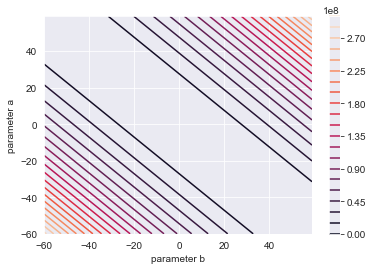

In [308]:
a = np.arange(-60, 60, 1)
b = np.arange(-60, 60, 1)

aa, bb = np.meshgrid(a, b, indexing='ij')

values = np.array((aa, bb)).T.reshape(-1, 2)

likelihood_values = np.zeros(values.shape[0])

for idx, val in enumerate(values):
    likelihood_values[idx] = likelihood(val, sample)
    
likelihood_values

plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("parameter a")
plt.xlabel("parameter b")
plt.colorbar()

In [309]:
initial_guess = rng.random(2)

print(initial_guess)

# def callbackF(Xi):
#     global nfev
#     print(f"{nfev}, {Xi[0]}, {Xi[1]}")
#     Nfeval += 1

lik_model = minimize(likelihood, x0=initial_guess,
                     args=(sample),
                     method="Nelder-Mead",
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

[0.5250883 0.1637513]
Optimization terminated successfully.
         Current function value: 893.249084
         Iterations: 61
         Function evaluations: 124


array([-0.01599511,  0.20213814])

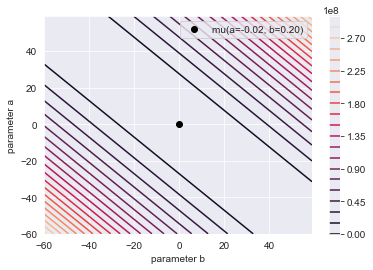

In [310]:
plt.contour(aa, bb, likelihood_values.reshape(aa.shape), 20)
plt.ylabel("parameter a")
plt.xlabel("parameter b")
plt.plot(lik_model.x[0], lik_model.x[1], 'ko', label=f"mu(a={lik_model.x[0]:.2f}, b={lik_model.x[1]:.2f})")
plt.legend()
plt.colorbar()